In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sbn 

import statsmodels.api as sm
from patsy import dmatrices

import os 

In [4]:
batch_res = pd.read_csv('./output/batch_effect_results.csv')
batch_res.head()

,batch,pc1_coef,pc1_pval,pc2_coef,pc2_pval,run_id
0,H210514_SET1,0.058274,0.745172,0.099506,0.088807,6bd9de4b-bd86-4e21-a87f-90688cfb8623
1,H210514_SET2,0.041153,0.818404,0.018284,0.750467,6bd9de4b-bd86-4e21-a87f-90688cfb8623
2,H210521_SET1,-0.022249,0.901192,0.077401,0.182626,6bd9de4b-bd86-4e21-a87f-90688cfb8623
3,H210521_SET2,0.003816,0.983010,-0.012736,0.824631,6bd9de4b-bd86-4e21-a87f-90688cfb8623
4,H210528_SET1,0.002086,0.990710,-0.051622,0.371264,6bd9de4b-bd86-4e21-a87f-90688cfb8623


In [5]:
run_res = pd.read_csv('./output/experiment_run_results.csv')
run_res.head()

,accuracy(train),pc1_var,pc2_var,kmeans_inertia,res_line,sens_line,drug,nclus,resample_sz,load,burnin,batch_corrected,run_id,cell_line,drug_check
0,0.785714,0.597874,0.224172,5.434913,T798I,WT,neratinib,5,150,raw,0,False,6bd9de4b-bd86-4e21-a87f-90688cfb8623,EFM192A,NERATINIB
1,0.857143,0.407124,0.152948,3.588358,T798I,WT,neratinib,25,150,raw,8,False,112e3264-f60e-4e5d-a99d-7b63686bdbc7,EFM192A,NERATINIB
2,0.857143,0.601909,0.225280,3.423416,T798I,WT,neratinib,5,100,raw,8,True,2b29593b-9bc6-4a55-b7e0-9395fabc7023,EFM192A,NERATINIB
3,0.821429,0.373280,0.156180,2.526649,T798I,WT,neratinib,25,100,raw,0,True,6f7956a2-292a-4ae0-b35b-ff187d2164d8,EFM192A,NERATINIB
4,0.785714,0.602321,0.224342,3.423421,T798I,WT,neratinib,5,100,raw,8,False,0cce69a1-f52c-454e-9f15-95222e54eb3c,EFM192A,NERATINIB


In [6]:
mut_res = pd.read_csv('./output/mutant_resistance_results.csv')
mut_res.head()

,pc1,pc2,treatment,mutant,batch,cell_count,prob_res,prob_sens,call,run_id,cell_line,drug_check,pc1_coef,pc1_pval,pc2_coef,pc2_pval,pc1_uncor,pc2_uncor
0,0.525777,0.125569,neratinib,A1160V,H210820,207,0.150340,0.849660,sens,6bd9de4b-bd86-4e21-a87f-90688cfb8623,EFM192A,NERATINIB,NaN,NaN,NaN,NaN,NaN,NaN
1,0.109011,-0.300311,neratinib,A355QFS76,H210827_SET1,346,0.829766,0.170234,res,6bd9de4b-bd86-4e21-a87f-90688cfb8623,EFM192A,NERATINIB,NaN,NaN,NaN,NaN,NaN,NaN
2,0.127381,-0.070072,neratinib,A37T,H210827_SET2,234,0.713837,0.286163,res,6bd9de4b-bd86-4e21-a87f-90688cfb8623,EFM192A,NERATINIB,NaN,NaN,NaN,NaN,NaN,NaN
3,0.249748,-0.188780,neratinib,D639E,H210827_SET1,360,0.815597,0.184403,res,6bd9de4b-bd86-4e21-a87f-90688cfb8623,EFM192A,NERATINIB,NaN,NaN,NaN,NaN,NaN,NaN
4,0.034218,-0.316438,neratinib,G778P780DUP,H210820,28,0.775145,0.224855,res,6bd9de4b-bd86-4e21-a87f-90688cfb8623,EFM192A,NERATINIB,NaN,NaN,NaN,NaN,NaN,NaN


# Train accuracy 

This is a good metric of how easily sepearable the classes are.

In [7]:
y, X = dmatrices('accuracy ~ nclus + resample_sz + load + burnin', data=run_res.rename({'accuracy(train)':'accuracy'}, axis=1), return_type='dataframe')
mod = sm.OLS(y, X) 
fit = mod.fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:               accuracy   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.156
Date:                Tue, 25 Jan 2022   Prob (F-statistic):              0.331
Time:                        18:24:36   Log-Likelihood:                 435.57
No. Observations:                 288   AIC:                            -861.1
Df Residuals:                     283   BIC:                            -842.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.9462      0.011     84.851      

# Batch Effects 

In [8]:
batch_res2 = batch_res.assign(PC1_flag = lambda x: x.pc1_pval < 0.05,
                               PC2_flag = lambda x: x.pc2_pval < 0.05)

batch_res2 = batch_res2.assign(any_flag=lambda x: (x.PC1_flag | x.PC2_flag))

x = mut_res[['cell_line', 'treatment', 'run_id']].drop_duplicates()

batch_res2 = batch_res2.merge(x, on='run_id', how='left')

batch_sum = batch_res2[['batch', 'treatment', 'PC1_flag', "PC2_flag", 'any_flag']].groupby(['batch', 'treatment']).mean().reset_index()
batch_sum.head()

,batch,treatment,PC1_flag,PC2_flag,any_flag
0,H210205_SET1_2,neratinib,0.0,0.000000,0.000000
1,H210205_SET1_2,trastuzumab,0.0,0.000000,0.000000
2,H210205_SET2_2,neratinib,0.0,0.000000,0.000000
3,H210205_SET2_2,trastuzumab,0.0,0.000000,0.000000
4,H210212_SET1,neratinib,0.0,0.013889,0.013889


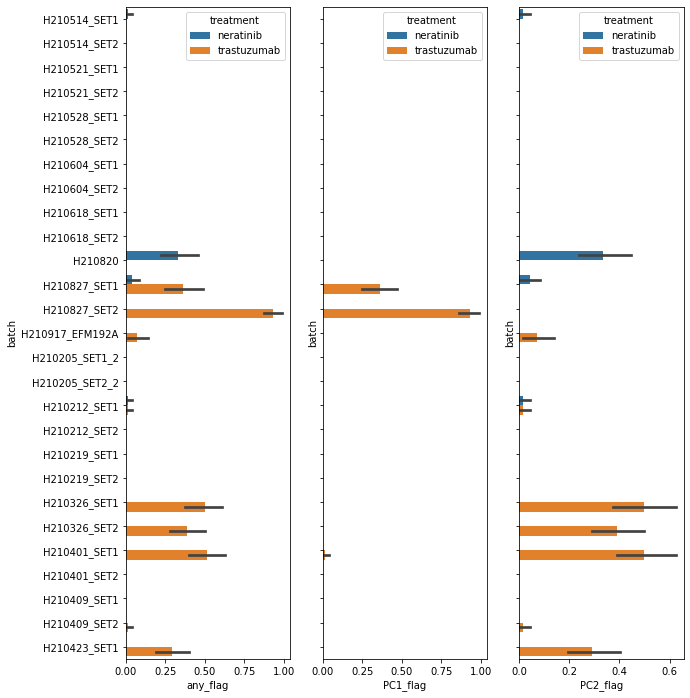

In [9]:
f, axes = plt.subplots(1,3, figsize=(10,12), sharey=True)
sbn.barplot(y='batch', x='any_flag', hue='treatment', data=batch_res2, ax=axes[0])
sbn.barplot(y='batch', x='PC1_flag', hue='treatment', data=batch_res2, ax=axes[1])
sbn.barplot(y='batch', x='PC2_flag', hue='treatment', data=batch_res2, ax=axes[2])
plt.show()

In [10]:
batch_res.batch.unique()

array(['H210514_SET1', 'H210514_SET2', 'H210521_SET1', 'H210521_SET2',
       'H210528_SET1', 'H210528_SET2', 'H210604_SET1', 'H210604_SET2',
       'H210618_SET1', 'H210618_SET2', 'H210820', 'H210827_SET1',
       'H210827_SET2', 'H210917_EFM192A', 'H210205_SET1_2',
       'H210205_SET2_2', 'H210212_SET1', 'H210212_SET2', 'H210219_SET1',
       'H210219_SET2', 'H210326_SET1', 'H210326_SET2', 'H210401_SET1',
       'H210401_SET2', 'H210409_SET1', 'H210409_SET2', 'H210423_SET1'],
      dtype=object)

In [11]:
myres = mut_res.merge(run_res, on='run_id', how='left')
myres.head()

,pc1,pc2,treatment,mutant,batch,cell_count,prob_res,prob_sens,call,run_id,...,res_line,sens_line,drug,nclus,resample_sz,load,burnin,batch_corrected,cell_line_y,drug_check_y
0,0.525777,0.125569,neratinib,A1160V,H210820,207,0.150340,0.849660,sens,6bd9de4b-bd86-4e21-a87f-90688cfb8623,...,T798I,WT,neratinib,5,150,raw,0,False,EFM192A,NERATINIB
1,0.109011,-0.300311,neratinib,A355QFS76,H210827_SET1,346,0.829766,0.170234,res,6bd9de4b-bd86-4e21-a87f-90688cfb8623,...,T798I,WT,neratinib,5,150,raw,0,False,EFM192A,NERATINIB
2,0.127381,-0.070072,neratinib,A37T,H210827_SET2,234,0.713837,0.286163,res,6bd9de4b-bd86-4e21-a87f-90688cfb8623,...,T798I,WT,neratinib,5,150,raw,0,False,EFM192A,NERATINIB
3,0.249748,-0.188780,neratinib,D639E,H210827_SET1,360,0.815597,0.184403,res,6bd9de4b-bd86-4e21-a87f-90688cfb8623,...,T798I,WT,neratinib,5,150,raw,0,False,EFM192A,NERATINIB
4,0.034218,-0.316438,neratinib,G778P780DUP,H210820,28,0.775145,0.224855,res,6bd9de4b-bd86-4e21-a87f-90688cfb8623,...,T798I,WT,neratinib,5,150,raw,0,False,EFM192A,NERATINIB


In [12]:
myres.batch_corrected.unique()

array([False,  True])

In [13]:
myres.groupby(['mutant', 'batch_corrected', 'treatment', 'cell_line_x'])['prob_res'].mean()

mutant           batch_corrected  treatment    cell_line_x
A1039T           False            neratinib    EFM192A        0.743567
                                               SKBR3          0.325071
                                  trastuzumab  EFM192A        0.244116
                                               SKBR3          0.937257
                 True             neratinib    EFM192A        0.667954
                                                                ...   
Y772V773INSRDGE  True             trastuzumab  EFM192A        0.233533
Y835F            False            neratinib    SKBR3          0.450762
                                  trastuzumab  SKBR3          0.152561
                 True             neratinib    SKBR3          0.342401
                                  trastuzumab  SKBR3          0.084314
Name: prob_res, Length: 624, dtype: float64

In [14]:
# 50th Percentile
def q05(x):
    return x.quantile(0.05)

# 90th Percentile
def q95(x):
    return x.quantile(0.95)

In [15]:
df = mut_res.groupby(['cell_line', 'treatment', 'mutant'])['prob_res'].agg(['mean', 'std', q05, q95, 'min', 'max']).sort_values('mean', ascending=False)

df.head()

mean       std       q05       q95  \
cell_line treatment   mutant                                           
EFM192A   trastuzumab S609C   0.962598  0.018717  0.929190  0.985113   
SKBR3     trastuzumab I767M   0.943874  0.029313  0.891345  0.977509   
          neratinib   L785F   0.942944  0.009990  0.928139  0.963562   
          trastuzumab T733I   0.939100  0.023061  0.903215  0.971299   
                      V842I   0.936447  0.027586  0.877672  0.968723   

                                   min       max  
cell_line treatment   mutant                      
EFM192A   trastuzumab S609C   0.884330  0.988190  
SKBR3     trastuzumab I767M   0.828813  0.983788  
          neratinib   L785F   0.912650  0.966372  
          trastuzumab T733I   0.885847  0.975775  
                      V842I   0.855353  0.976343

In [21]:
df.loc[('EFM192A', 'neratinib')].sort_values('mean', ascending=False)[lambda x: x['mean'] > 0.5]

/tmp/ipykernel_17163/753586176.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[('EFM192A', 'neratinib')].sort_values('mean', ascending=False)[lambda x: x['mean'] > 0.5]


,mean,std,q05,q95,min,max
mutant,,,,,,
G778S779INSLPS,0.886930,0.048912,0.797280,0.949602,0.768489,0.957924
E405D,0.871505,0.037340,0.811310,0.920647,0.756116,0.940467
E717K,0.871093,0.051300,0.764641,0.933338,0.748763,0.953540
I435L,0.865247,0.057874,0.752367,0.938256,0.738533,0.954325
P523S,0.834023,0.048452,0.744968,0.899111,0.702041,0.914859
L313V,0.819357,0.053186,0.720255,0.895762,0.684823,0.911675
N427K,0.798898,0.065416,0.667068,0.879015,0.662180,0.889815
D873G,0.793570,0.113592,0.580417,0.907242,0.473703,0.916912
H470Q,0.780173,0.135594,0.443975,0.911769,0.392620,0.917716


In [22]:
df.loc[('EFM192A', 'neratinib')][lambda x: ((x.q05 > 0.25) & (x.q95 < 0.75))]

/tmp/ipykernel_17163/3424073894.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[('EFM192A', 'neratinib')][lambda x: ((x.q05 > 0.25) & (x.q95 < 0.75))]


,mean,std,q05,q95,min,max
mutant,,,,,,
D769Y,0.594823,0.091461,0.454183,0.726897,0.349088,0.768644
P232S,0.570726,0.106971,0.386302,0.704742,0.319430,0.727630
L869R,0.529652,0.060099,0.451836,0.631098,0.363609,0.648938
L755S,0.514263,0.106504,0.360704,0.665976,0.288892,0.774477
V697L,0.502126,0.118075,0.338873,0.726515,0.256560,0.780375
G727A,0.485036,0.158587,0.280169,0.743166,0.210469,0.790898
Q1206K,0.481897,0.136280,0.304535,0.734180,0.234893,0.764000
Y772A775DUP,0.461797,0.050471,0.389592,0.543949,0.343968,0.559330


In [23]:
df.loc[('SKBR3', 'neratinib')][lambda x: x['mean'] > 0.5]

/tmp/ipykernel_17163/359209146.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[('SKBR3', 'neratinib')][lambda x: x['mean'] > 0.5]


,mean,std,q05,q95,min,max
mutant,,,,,,
L785F,0.942944,0.009990,0.928139,0.963562,0.912650,0.966372
T798I,0.934300,0.024709,0.907451,0.956677,0.580588,0.969322
G778S779INSLPS,0.816992,0.152115,0.497074,0.939925,0.326697,0.959004
V797A,0.805203,0.069656,0.670901,0.900503,0.658632,0.917700
Y722V773INSRDGE,0.730067,0.151137,0.450922,0.906197,0.308982,0.940355
V842I,0.704006,0.181306,0.381661,0.934868,0.253806,0.948235
R929WL,0.640658,0.181637,0.302081,0.829535,0.197119,0.845581
R456C,0.529554,0.231559,0.156253,0.812433,0.101409,0.882055
R678Q,0.525914,0.247766,0.177099,0.922775,0.145272,0.936666


In [19]:
df.loc[('EFM192A', 'trastuzumab')][lambda x: x['mean'] > 0.5]

/tmp/ipykernel_17163/377190337.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[('EFM192A', 'trastuzumab')][lambda x: x['mean'] > 0.5]


,mean,std,q05,q95,min,max
mutant,,,,,,
S609C,0.962598,0.018717,0.929190,0.985113,0.884330,0.988190
L755S,0.933068,0.044884,0.864925,0.976581,0.726672,0.978085
Y772A775DUP,0.915079,0.076374,0.773128,0.979507,0.543049,0.984697
ND611,0.909959,0.135314,0.629449,0.979413,0.165377,0.988439
L869R,0.907359,0.025034,0.863184,0.939489,0.840237,0.959214
E939G,0.809150,0.110345,0.571470,0.957408,0.457780,0.973904
R456C,0.758095,0.179174,0.448022,0.971038,0.285531,0.975933
D638H,0.742537,0.252461,0.297077,0.983854,0.084844,0.985125
V842I,0.703113,0.251194,0.217813,0.971957,0.114426,0.986577


In [20]:
df.loc[('SKBR3', 'trastuzumab')][lambda x: x['mean'] > 0.5]

/tmp/ipykernel_17163/1948531870.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[('SKBR3', 'trastuzumab')][lambda x: x['mean'] > 0.5]


,mean,std,q05,q95,min,max
mutant,,,,,,
I767M,0.943874,0.029313,0.891345,0.977509,0.828813,0.983788
T733I,0.939100,0.023061,0.903215,0.971299,0.885847,0.975775
V842I,0.936447,0.027586,0.877672,0.968723,0.855353,0.976343
D769N,0.928160,0.029077,0.877449,0.967185,0.826130,0.984446
D873G,0.927718,0.046837,0.853133,0.972149,0.671390,0.987794
R897G,0.913032,0.050424,0.825972,0.970977,0.777903,0.988682
T862S,0.913005,0.038685,0.853686,0.960726,0.791781,0.968792
R456C,0.909091,0.039561,0.834597,0.957698,0.808827,0.968967
A1039T,0.905519,0.052529,0.801159,0.962126,0.761438,0.970325


In [64]:
mut_res2 = mut_res.merge(batch_sum, on=['batch', 'treatment'], how='left')
mut_res2.head()

,pc1,pc2,treatment,mutant,batch,pc1_coef,pc1_pval,pc2_coef,pc2_pval,run_id,pc1_uncor,pc2_uncor,prob_res,prob_sens,call,cell_line,drug_check,PC1_flag,PC2_flag,any_flag
0,0.531720,0.265560,neratinib,A1160V,H210820,-0.001453,0.993542,-0.130896,0.025425,b5f1b872-e62d-4aec-8fee-53ed3f760116,0.530267,0.134664,0.103657,0.896343,sens,EFM192A,NERATINIB,0.0,0.319444,0.319444
1,0.056703,-0.189783,neratinib,G778P780DUP,H210820,-0.001453,0.993542,-0.130896,0.025425,b5f1b872-e62d-4aec-8fee-53ed3f760116,0.055250,-0.320679,0.849838,0.150162,res,EFM192A,NERATINIB,0.0,0.319444,0.319444
2,0.357022,0.009388,neratinib,L785F,H210820,-0.001453,0.993542,-0.130896,0.025425,b5f1b872-e62d-4aec-8fee-53ed3f760116,0.355570,-0.121507,0.200574,0.799426,sens,EFM192A,NERATINIB,0.0,0.319444,0.319444
3,-0.225782,-0.008562,neratinib,L869R,H210820,-0.001453,0.993542,-0.130896,0.025425,b5f1b872-e62d-4aec-8fee-53ed3f760116,-0.227235,-0.139458,0.506760,0.493240,res,EFM192A,NERATINIB,0.0,0.319444,0.319444
4,-0.058056,0.245986,neratinib,ND611,H210820,-0.001453,0.993542,-0.130896,0.025425,b5f1b872-e62d-4aec-8fee-53ed3f760116,-0.059508,0.115090,0.423131,0.576869,sens,EFM192A,NERATINIB,0.0,0.319444,0.319444


In [9]:
mut_res2['']

(37440, 14)

In [13]:
mut_res2[lambda x: x.PC1_flag.isna()].batch.unique()

array(['H210514_SET1', 'H210205_SET1_2'], dtype=object)

In [14]:
mut_res.groupby('batch')['mutant'].count()

batch
H210205_SET1_2     20
H210205_SET2_2     20
H210212_SET1       18
H210212_SET2       20
H210219_SET1       18
H210219_SET2       20
H210326_SET1       20
H210326_SET2       20
H210401_SET1       18
H210401_SET2       18
H210409_SET1       20
H210409_SET2       20
H210423_SET1       20
H210514_SET1       20
H210514_SET2       20
H210521_SET1       20
H210521_SET2       20
H210528_SET1       18
H210528_SET2       16
H210604_SET1       20
H210604_SET2       20
H210618_SET1       20
H210618_SET2       20
H210820            14
H210827_SET1       20
H210827_SET2       20
H210917_EFM192A    20
Name: mutant, dtype: int64

In [110]:
mut_res.shape

(520, 11)

In [111]:
mut_res2.shape

(520, 14)

In [20]:
norm = lambda x, y: (x-min(y))/ (max(y) - min(y)) 

nclus_ = {row.run_id:[0., 1- norm(row.nclus,run_res.nclus),0., 0.5] for i,row in run_res.iterrows()}
nclus_colors = run_res['run_id'].map(nclus_).rename('nclus')

load_ = {row.run_id:'k' if (row.load == 'normalized') else 'w' for i,row in run_res.iterrows()}
load_colors = run_res['run_id'].map(load_).rename('load')

resamp_ = {row.run_id:[1 - norm(row.resample_sz,run_res.resample_sz), 0., 0., 0.5] for i,row in run_res.iterrows()}
resamp_colors = run_res['run_id'].map(resamp_).rename('resample_sz')

row_colors = pd.concat([nclus_colors, load_colors, resamp_colors], axis=1)
row_colors = row_colors.set_index(run_res.run_id)

#print(row_colors)

#ids_tokeep = run_res[lambda x: (x.nclus < 35)].run_id.values
#prob_res2 = prob_res[lambda x: x.run_id.isin(ids_tokeep)]

prob_res2 = mut_res.merge(run_res, on='run_id').pivot(columns='run_id', index='obs_id', values='prob_res')
res_mat = prob_res2.corr().fillna(0)
sbn.clustermap(res_mat, vmin=-1, vmax=1, center=0, row_colors=row_colors, figsize=(10,10))

KeyError: 'obs_id'

# concordant calls

In [15]:
conc_calls = prob_res.groupby(['obs_id', 'call']).count()[['run_id']].reset_index().set_index('obs_id').pivot(columns='call', values='run_id').assign(prop_call_res=lambda x: x.res / (x.res + x.sens))

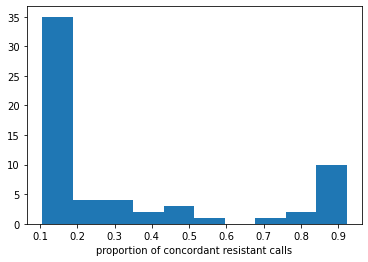

In [70]:
plt.figure()
plt.hist(conc_calls.prop_call_res)
plt.xlabel('proportion of concordant resistant calls')
plt.show()

In [17]:
np.sum( conc_calls.prop_call_res > 0.75 )

12

In [18]:
conc_res_obs_ids = conc_calls[conc_calls.prop_call_res > 0.75].reset_index().obs_id

In [19]:
prob_res[lambda x: x.obs_id.isin(conc_res_obs_ids)].cell_line.unique()

array(['G778S779insLPS', 'L755T759DEL', 'R456C', 'R678Q', 'T798I',
       'V842I', 'Y835F'], dtype=object)

# Model variance 

Same config params, same results? 

In [59]:
def get_model_variance_stats(nclus, load, sz): 
    
    _ids = run_res[lambda x: (x.nclus==nclus) & (x.load == load) & (x.resample_sz == sz)].run_id
    mvar_ = prob_res[lambda x: x.run_id.isin(_ids)]
    mvar_res = mvar_[['run_id', 'obs_id', 'prob_res']].pivot(columns='run_id', values='prob_res', index='obs_id')
    mvar_mat = mvar_res.corr()

    triu_idx = np.triu_indices(mvar_mat.shape[0], k=1)
    corrs = mvar_mat.values[triu_idx]
    corr_mean = corrs.mean()
    corr_std = corrs.std()
    corr_min = corrs.min()
    corr_max = corrs.max()
    return corr_mean, corr_std, corr_min, corr_max

var_res = {'nclus':[], 'load':[], 'resample_sz':[], 'corr_mean':[], 'corr_std':[], 'corr_min':[], 'corr_max':[]}
for nc in run_res.nclus.unique(): 
    for l in run_res.load.unique(): 
        for sz in run_res.resample_sz.unique(): 
            corr_mean, corr_std, corr_min, corr_max = get_model_variance_stats(nc, l, sz)
            var_res['nclus'].append(nc)
            var_res['load'].append(l)
            var_res['resample_sz'].append(sz)
            var_res['corr_mean'].append(corr_mean)
            var_res['corr_std'].append(corr_std)
            var_res['corr_min'].append(corr_min)
            var_res['corr_max'].append(corr_max)
            
var_res = pd.DataFrame(var_res).assign(corr_min_unit = lambda x: x.corr_min.clip(0,1))
var_res.head()

,nclus,load,resample_sz,corr_mean,corr_std,corr_min,corr_max,corr_min_unit
0,15,raw,75,0.935192,0.020712,0.905259,0.972514,0.905259
1,15,raw,150,0.938284,0.016595,0.902949,0.969040,0.902949
2,15,raw,125,0.949348,0.019311,0.919606,0.982665,0.919606
3,15,raw,50,0.908513,0.033114,0.834107,0.959517,0.834107
4,15,raw,100,0.938958,0.017862,0.906228,0.966396,0.906228


In [60]:
lm = logit('corr_min_unit ~ nclus + resample_sz + load', data=var_res).fit() #Specify C for Categorical
print(lm.params)
print()
print(lm.conf_int())
#print()
#print(sm.stats.anova_lm(lm))

Optimization terminated successfully.
         Current function value: 0.197250
         Iterations 7
Intercept      4.222236
load[T.raw]   -0.420407
nclus         -0.162454
resample_sz    0.002738
dtype: float64

                    0         1
Intercept    1.429946  7.014527
load[T.raw] -1.919332  1.078518
nclus       -0.229108 -0.095800
resample_sz -0.018269  0.023746


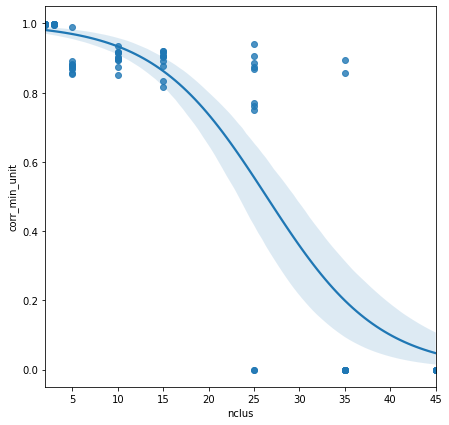

In [61]:
plt.figure(figsize=(7,7))
sbn.regplot(x='nclus', y='corr_min_unit', data=var_res, logistic=True)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

No handles with labels found to put in legend.


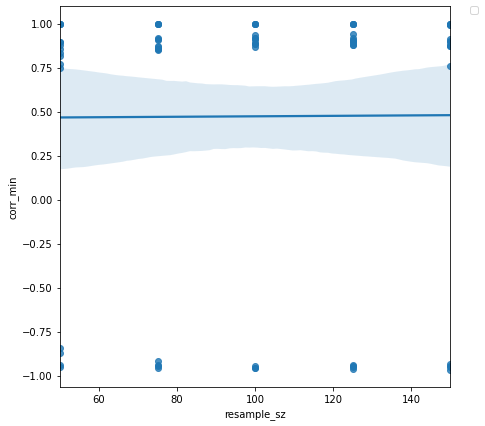

In [54]:
plt.figure(figsize=(7,7))
sbn.regplot(x='resample_sz', y='corr_min', data=var_res, logistic=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

No handles with labels found to put in legend.


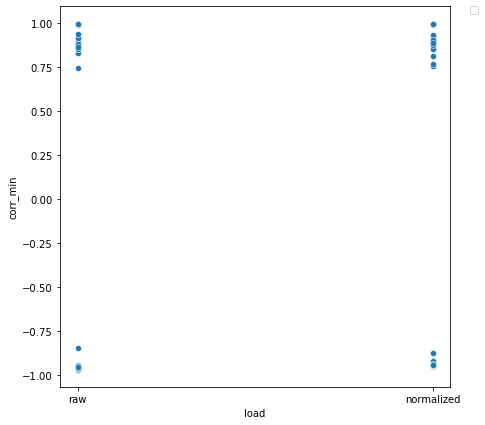

In [41]:
plt.figure(figsize=(7,7))
sbn.scatterplot(x='load', y='corr_min', data=var_res)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Stable Configs


In [71]:
var_res.head()

,nclus,load,resample_sz,corr_mean,corr_std,corr_min,corr_max,corr_min_unit
0,15,raw,75,0.935192,0.020712,0.905259,0.972514,0.905259
1,15,raw,150,0.938284,0.016595,0.902949,0.969040,0.902949
2,15,raw,125,0.949348,0.019311,0.919606,0.982665,0.919606
3,15,raw,50,0.908513,0.033114,0.834107,0.959517,0.834107
4,15,raw,100,0.938958,0.017862,0.906228,0.966396,0.906228


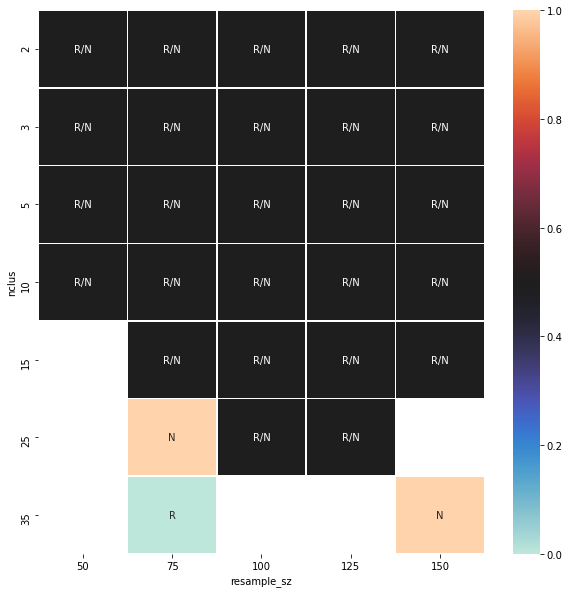

In [113]:
var_res2 = var_res[lambda x: x.corr_min > 0.85][['resample_sz', 'nclus', 'load']].groupby(['resample_sz', 'nclus']).agg('-'.join).reset_index()
var_mat = var_res2.assign(load= [0 if x=='raw' else (1 if x=='normalized' else 0.5) for x in var_res2.load])
labels = var_res2.assign(load= ['R' if x=='raw' else ('N' if x=='normalized' else 'R/N') for x in var_res2.load]).pivot(columns='resample_sz', index='nclus', values='load')
var_mat = var_mat.pivot(columns='resample_sz', index='nclus', values='load')

plt.figure(figsize=(10,10))
sbn.heatmap(var_mat, linewidths=.5, annot=labels.values, fmt='', vmin=0, vmax=1, center=0.5)
plt.show()

In [139]:
acc_mat

load
resample_sz nclus      
50          2       1.0
            3       1.0
            10      1.0
75          2       1.0
            3       0.5
            10      1.0
            15      1.0
100         2       1.0
            3       1.0
            10      1.0
125         2       1.0
            3       0.5
            10      1.0
            15      1.0
150         2       1.0
            3       0.5
            10      1.0
            15      1.0

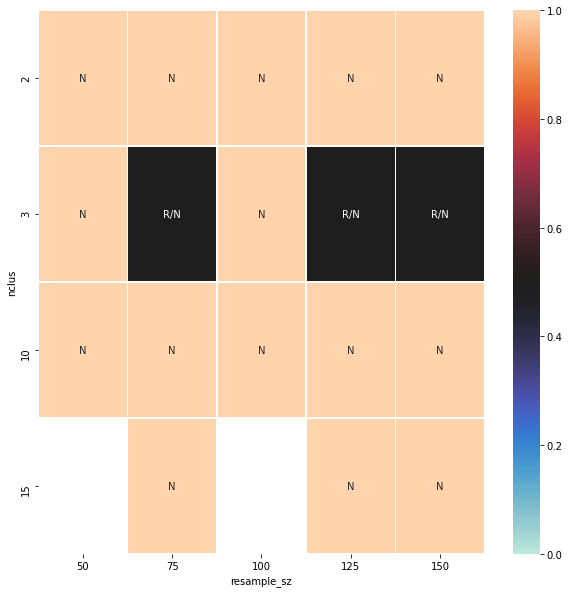

In [142]:
hi_ac = run_res.groupby(['nclus', 'resample_sz', 'load']).agg('mean')[['accuracy(train)']][lambda x: x['accuracy(train)'] == 1.]

hi_ac = hi_ac.reset_index()[['nclus', 'resample_sz', 'load']].groupby(['resample_sz', 'nclus']).agg('-'.join).reset_index()

acc_mat = hi_ac.assign(load= [0 if x=='raw' else (1 if x=='normalized' else 0.5) for x in hi_ac.load]).pivot(columns='resample_sz', index='nclus', values='load')
labels = hi_ac.assign(load= ['R' if x=='raw' else ('N' if x=='normalized' else 'R/N') for x in hi_ac.load]).pivot(columns='resample_sz', index='nclus', values='load')

plt.figure(figsize=(10,10))
sbn.heatmap(acc_mat, linewidths=.5, annot=labels.values, fmt='', vmin=0, vmax=1, center=0.5)
plt.show()

In [121]:


plt.figure(figsize=(10,10))
sbn.heatmap(var_mat, linewidths=.5, annot=labels.values, fmt='', vmin=0, vmax=1, center=0.5)
plt.show()

accuracy(train)
nclus resample_sz load                       
2     50          normalized              1.0
      75          normalized              1.0
      100         normalized              1.0
      125         normalized              1.0
      150         normalized              1.0
3     50          normalized              1.0
      75          normalized              1.0
                  raw                     1.0
      100         normalized              1.0
      125         normalized              1.0
                  raw                     1.0
      150         normalized              1.0
                  raw                     1.0
10    50          normalized              1.0
      75          normalized              1.0
      100         normalized              1.0
      125         normalized              1.0
      150         normalized              1.0
15    75          normalized              1.0
      125         normalized              1.0
      150         normalized              1.0